# Chapter 6 합성곱 신경망

## 6.1 합성곱 연산과 풀링 연산

### 6.1.1 이미지 데이터
- ex) 128x128x3은 크기가 128x128 행렬 이미지며, 3채널(RGB)
- 이미지 처리 Image processing

### 6.1.2 MLP와 이미지 처리
- MLP 구조를 이용하여 사각형 모양의 사진을 처리하려면 이미지를 일렬 형태로 변환 후 모델에 입력시켜야 함 ex) 3x3 이미지 행렬 -> 9x1 벡터가 됨
- 그런데 이는 행렬의 성분을 순서대로 일렬로 붙여 벡터화하기에 이미지 내 같은 객체가 있더라도 그 위치나 크기가 조금만 달라져도 크게 변화하기에 좋은 성능을 내기 어려움
- 따라서 전체 이미지를 벡터화하지 않고 이미지의 일부분을 하나씩 살펴 보면서 전체 이미지를 해석하자 => CNN

### 6.1.3 합성곱 연산과 풀링 연산
- 이미지의 일부분을 차례로 훑어 보며 이미지 전체 파악하는 법
  - 합성곱 Convolution: 특정 값을 지닌 Filter 혹은 Kernel을 가지고 해당 부분의 이미지 값과 연산하는 방법. Filter에 따라 추출되는 특성이 다르기 때문에 모델 최적화를 통해 적절한 Filter의 값을 찾는 것이 목표.
  - 풀링 Pooling

In [ ]:
# 합성곱 연산: filter가 위치한 부분에서 동일한 위치의 성분끼리 곱하여 전체를 더하는 것
# 1. filter가 움직이는 보폭 Stride 지정, 2. 이미지 밖을 특정 값으로 둘러쌓는 패딩 Padding

nn.Conv2d
torch.nn.functional.conv2d

In [ ]:
# 풀링 연산: 합성곱과 같은 방법으로 진행되지만 커널 안에서의 연산이 다름
# 1. 영역 내 최댓값 풀링 Max pooling, 2. 평균값 풀링 Average pooling
# 풀링은 커널의 크기와 보폭을 같게 함으로써 non-overlapping pooling 이동하는 커널이 같은 부분을 중복 계산하지 않게 함
# 즉, 영역별 대푯값을 하나씩 뽑아내는 연산이며 주로 컨볼루션 층 다음에 배치

nn.AvgPool2d
torch.nn.functional.avg_pool2d

nn.MaxPool2d
torch.nn.functioanl.max_pool2d

## 6.2 AlexNet
- 기본적인 CNN 모델

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [14]:
# CIFAR10 데이터셋 불러오기

# 튜플: 각 채널 당 평균 할당, 표준편차
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
# GPU 연산 체크하기

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [16]:
# AlexNet 구축하기

class AlexNet(nn.Module):
  def __init__(self):
    super(AlexNet, self).__init__()
    # self.features는 합성곱 연산과 풀링 연산이 행해지는 피쳐 추출 Feature extraction 부분
    # nn.Sequential은 순차적으로 행해지는 연산을 한 번에 묶음. 괄호 안 작성 순서대로 연산 수행
    self.features = nn.Sequential(
        nn.Conv2d(3,64,3), nn.ReLU(), # (입력 채널 수, 출력 채널 수, 필터의 크기)
        nn.MaxPool2d(2,2), # 최댓값 풀링 (필터의 크기, 보폭)
        nn.Conv2d(64,192,3,padding=1), nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(192,384,3,padding=1), nn.ReLU(),
        nn.Conv2d(384,256,3,padding=1), nn.ReLU(),
        nn.Conv2d(256,256,1), nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    # Fully-connected layer
    self.classifier = nn.Sequential(
        nn.Dropout(0.5),
        # 처음 들어오는 입력값의 크기와 self.features에서 나온 피쳐맵을 일렬로 편 벡터의 크기가 같아야 함
        nn.Linear(256*3*3,1024), nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024,512), nn.ReLU(),
        # CIFAR10은 10개의 클래스를 가진 데이터
        nn.Linear(512,10)
    )

  def forward(self, x):
    x = self.features(x)
    x = x.view(-1,256*3*3)
    x = self.classifier(x)
    return x

In [17]:
# 손실 함수 및 최적화 방법 정의하기
# 다중 분류 문제에서는 Cross Entropy Loss를 기본으로 사용, 별도의 softmax 적용 안 해도 됨

criterion = nn.CrossEntropyLoss()
alexnet = AlexNet().to(device) # GPU 연산을 위해 모델을 불러올 때 .to(device)
optimizer = optim.Adam(alexnet.parameters(), lr=1e-3)

In [9]:
# AlexNet 모델 학습하기

loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트
n = len(trainloader) # 배치 개수
for epoch in range(50):
  running_loss = 0.0
  for data in trainloader:
    inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터
    optimizer.zero_grad()
    outputs = alexnet(inputs) # 예측값 산출
    loss = criterion(outputs, labels) # 손실 함수 계산
    loss.backward() # 손실 함수 기준으로 역전파 선언
    optimizer.step() # 가중치 최적화
    running_loss += loss.item()

  loss_.append(running_loss / n)
  print('[%d] loss: %.3f' %(epoch + 1, running_loss / len(trainloader)))

[1] loss: 0.371
[2] loss: 0.357
[3] loss: 0.340
[4] loss: 0.331
[5] loss: 0.339
[6] loss: 0.315
[7] loss: 0.312
[8] loss: 0.304
[9] loss: 0.297
[10] loss: 0.301
[11] loss: 0.283
[12] loss: 0.306
[13] loss: 0.286
[14] loss: 0.265
[15] loss: 0.263
[16] loss: 0.269
[17] loss: 0.269
[18] loss: 0.249
[19] loss: 0.250
[20] loss: 0.270
[21] loss: 0.257
[22] loss: 0.248
[23] loss: 0.277
[24] loss: 0.256
[25] loss: 0.241
[26] loss: 0.250
[27] loss: 0.252
[28] loss: 0.254
[29] loss: 0.225
[30] loss: 0.250
[31] loss: 0.272
[32] loss: 0.258
[33] loss: 0.255
[34] loss: 0.244
[35] loss: 0.259
[36] loss: 0.247
[37] loss: 0.245
[38] loss: 0.286
[39] loss: 0.231
[40] loss: 0.308
[41] loss: 0.268
[42] loss: 0.262
[43] loss: 0.240
[44] loss: 0.268
[45] loss: 0.317
[46] loss: 0.381
[47] loss: 0.249
[48] loss: 0.347
[49] loss: 0.279
[50] loss: 0.491


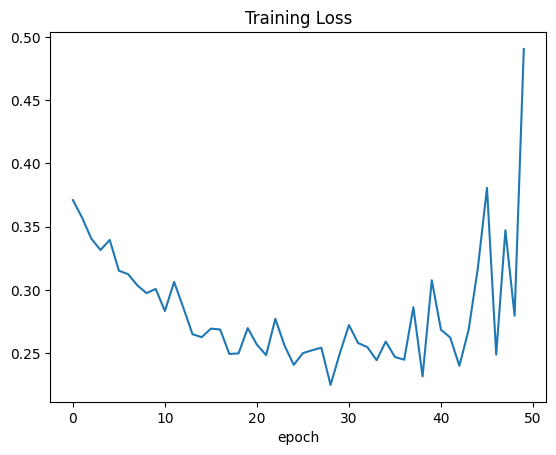

In [11]:
# 학습 손실 함수 그래프 그리기

plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [18]:
# 파이토치 모델 저장 및 불러오기

PATH = './models/cifar_alexnet.pth'
torch.save(alexnet.state_dict(),PATH)

In [19]:
alexnet = AlexNet().to(device)
alexnet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [20]:
# 평가하기

correct = 0
total = 0
with torch.no_grad():
  alexnet.eval()
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = alexnet(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0) # 개수 누적(총 개수)
    correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)

print('Test accuracy: %.2f %%' % (100 * correct / total))

Test accuracy: 10.00 %


## 6.3 ResNet
- Residual block: 여러 레이어를 건너 뛰어 이전 정보를 더하는 스킵 커넥션의 과정을 묶어 만든 것 (기본적으로 합성곱 층 2,3칸을 뛰어넘음) => 이를 여러 개 붙여놓은 모델
- 모델명에 붙은 숫자는 층의 개수 의미
- 기본층에서 7x7  필터를 사용하는 합성곱과 3x3 맥스 풀링 사용

In [22]:
# Residual block 구축하기

class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(ResidualBlock, self).__init__()
    self.stride = stride
    self.in_channels = in_channels
    self.out_channels = out_channels
    # 컨볼루션 연산 2개를 포함한 블록 만들어줌
    self.conv_block = nn.Sequential(
        # 학습을 빠르게 할 수 있는 배치 정규화(각 배치의 평균과 분산을 이용)를 층 사이 적용
        nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=stride,
                  padding=1, bias=False), nn.BatchNorm2d(self.out_channels), nn.ReLU(),
        nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1,
                  bias=False), nn.BatchNorm2d(self.out_channels)
    )
    # ResNet은 ResidualBlock 하나를 거칠 때마다 이미지 사이즈가 줄어들고 채널 수는 늘어나는 구조
    # 따라서 처음 들어오는 x값과 블록을 거친 출력값 out의 크기가 같아야만 함
    # 따라서 차이가 나는 경우 출력값의 크기와 입력값의 크기를 동일하게 하기 위해 별도의 컨볼루션 연산을 진행하여 입력 크기를 출력 크기와 맞춰줌
    if self.stride != 1 or self.in_channels != self.out_channels:
      self.downsample = nn.Sequential(
          nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1,
                    stride=stride, bias=False), nn.BatchNorm2d(self.out_channels)
      )

  def forward(self, x):
    out = self.conv_block(x)
    # 사이즈 조정이 필요하다면 입력값의 크기 조정
    if self.stride != 1 or self.in_channels != self.out_channels:
      x = self.downsample(x)
    # Skip connection 시행
    out = F.relu(x + out)
    return out

In [25]:
# ResNet 모델 구축하기

class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes =10):
      super(ResNet, self).__init__()
      self.in_channels = 64
      # 입력 이미지가 들어와 연산을 수행하는 기본층 만들기
      self.base = nn.Sequential(
          nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False),
          nn.BatchNorm2d(64),
          nn.ReLU())
      # 기본층을 제외한 4개의 블록 묶음 선언
      self.layer1 = self._make_layer(64,num_blocks[0],stride=1)
      self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
      self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
      self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
      # 합성곱 층들을 지나면 최종적으로 크기가 4x4인 피쳐맵 512개가 나옴
      # 크기가 4x4인 평균 풀링을 이용하면 각 피쳐맵 당 1개의 평균값이 나오므로 성분이 512개인 벡터를 얻음
      self.gap = nn.AvgPool2d(4) # 필터 사이즈 4
      # 클래스가 10개인 이미지 분류 FC
      self.fc = nn.Linear(512,num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
      # 블록의 반복 횟수만큼 stride 저장
      strides =[stride]+[1]*(num_blocks-1)
      layers=[]
      for stride in strides:
        block = ResidualBlock(self.in_channels, out_channels, stride) # 출력 채널 크기와 다음 입력 채너러 크기 동일시
        layers.append(block)
        self.in_channels = out_channels
      return nn.Sequential(*layers)

In [26]:
def forward(self, x):
  out = self.base(x)
  out = self.layer1(out)
  out = self.layer2(out)
  out = self.layer3(out)
  out = self.layer4(out)
  out = self.gap(out)
  out = out.view(out.size(0),-1)
  out = self.fc(out)
  return out

In [27]:
# 각 모델마다 블록의 반복 횟수를 리스트로 정의하여 입력
# 이를 통해 18, 34 외에 4개의 블록을 가진 레이어의 개수를 조정할 수 있음

def modeltype(model):
  if model == 'resnet18':
    return ResNet([2,2,2,2])
  elif model == 'resnet34':
    return ResNet([3,4,6,3])

In [28]:
resnet = modeltype('resnet18').to(device)
print(resnet)
path = './models/cifar_resnet.pth'

ResNet(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kerne